In [26]:
import os
import pandas as pd
import numpy as np
import pickle
import glob
import json
from json import JSONDecodeError
import requests
import csv
from collections import Counter,defaultdict
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Migrate results to [spreadsheet here](https://docs.google.com/spreadsheets/u/1/d/1_Ewrnb9gPkMfJaXhM71RAg7V8NhggU4OkJ5Q_ZctW-c/edit#gid=1747817466). Annotated spreadsheet with qualitative observations is [here](https://docs.google.com/spreadsheets/d/1wspavttD7o6e3UdreYwb-Bd5wd7eMM4bAPlxEztHLaY/edit#gid=0).

# Load data

In [2]:
reddit_dir = 'reddit_data'

In [3]:
posts_df = pd.read_pickle(os.path.join(reddit_dir,'posts_with_words.pkl'))
posts_df.reset_index(drop=True,inplace=True)
posts_df.shape

(975950, 18)

In [4]:
comments_df = pd.read_pickle(os.path.join(reddit_dir,'comments_complete.pkl'))
comments_df.shape

(7991395, 10)

Exclude posts/comments from bot users:

In [351]:
bots = pickle.load(open('bots.pkl','rb'))
print(len(bots))

2805


In [16]:
posts_df = posts_df.loc[~posts_df.author.isin(bots)]
comments_df = comments_df.loc[~comments_df.author.isin(bots)]
print(len(posts_df),len(comments_df))

911496 7945799


Posts linked to comments and comment text:

In [ ]:
comment_ids_per_post = pd.read_csv('comment_ids_per_post.tsv',sep='\t',header=None)
post2comment_ids = dict(zip(comment_ids_per_post['post_id'],
                           comment_ids_per_post['comment_ids']))
post2comment_ids = {key: post2comment_ids[key].split(',') if isinstance(post2comment_ids[key],str) else []
                    for key in post2comment_ids}
post2comment_ids = {key: [x[3:] for x in post2comment_ids[key]] for key in post2comment_ids}
post2comment_ids['anbg0']

In [ ]:
comment_texts_df = pd.read_csv('text_per_comment.tsv',sep='\t',header=0)
comment_texts_df = comment_texts_df.loc[~pd.isnull(comment_texts_df.text)]
print(comment_texts_df.shape)
print(comment_texts_df.head())

Export data for other applications:

In [205]:
posts_with_comments = posts_df.loc[posts_df.num_comments > 0]
posts_with_comments.id.to_pickle('posts_with_comments_ids.pkl')

Load annotated subreddit info:

In [331]:
annotated_subs = pd.read_csv('most_common_subreddits.tsv',sep='\t',header=0)

In [10]:
#annotated_subs.head()

# Define helper functions

In [123]:
"""Log-odds computations."""
from math import log, sqrt

def log_odds(c, n):
    """
    log_odds(c1, c2)
    Computes log odds for count data.
    Args:
      c: count of event.
      n: count of all events for the first sample.
    Returns:
      The log odds.
    """
    try:
        return log(c) - log(n - c) # log(c/(n-c)); log((c/n)/(1-c/n)) = log(c/(n-c))
    except ValueError:
        print(c, n)

def log_odds_ratio(c1, n1, c2, n2):
    """
    log_odds_ratio(c1, n1, c2, n2)
    Computes log odds for two counts.
    Args:
      c1: count of the event in the first sample.
      n1: count of all events for the first sample.
      c2: count in the event in the second sample.
      n1: count of all events for the second sample.
    Returns:
      Log odds.
    """
    try:
        return log_odds(c1, n1) - log_odds(c2, n2)
    except ValueError:
        print(c1, n1, c2, n2)

In [171]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [130]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('words')
WORDS = set(nltk.corpus.words.words())
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def get_lemmas(x):
    
    if len(x) > 0:
        return json.dumps([lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w.lower())) 
                       for w in nltk.word_tokenize(x)])
    return None

[nltk_data] Downloading package words to /sailhome/yiweil/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [131]:
len(WORDS)

235892

# Get lemmas within posts/comments

In [72]:
posts_df['title_lemmas'] = posts_df.title.apply(get_lemmas)
posts_df['body_lemmas'] = posts_df.text.apply(get_lemmas)

In [74]:
posts_df['title_lemmas'].apply(lambda x: type(x)).value_counts()

<class 'str'>    911496
Name: title_lemmas, dtype: int64

In [75]:
posts_df['body_lemmas'].apply(lambda x: type(x)).value_counts()

<class 'NoneType'>    681742
<class 'str'>         229754
Name: body_lemmas, dtype: int64

In [ ]:
posts_df.to_pickle(os.path.join(reddit_dir,'posts_with_words.pkl'))

In [ ]:
comment_texts_df['lemmas'] = comment_texts_df.text.apply(get_lemmas)

# High vs. low engagement posts

## Thresholding

Need to set bounds for long and short comment-thread posts. First visualize distribution:

Text(0.5, 0, 'Log num. comments')

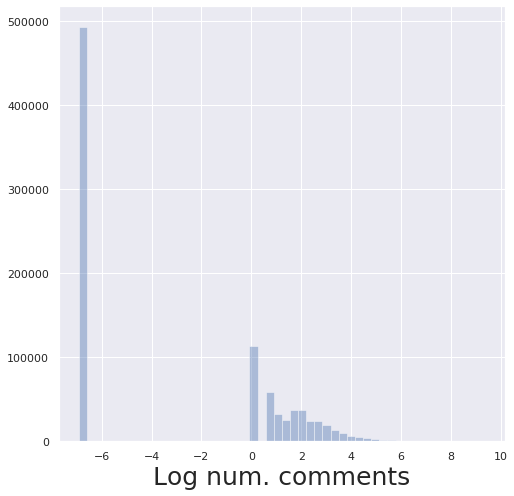

In [286]:
%matplotlib inline
posts_df['log_num_comments'] = posts_df['num_comments'].apply(lambda x: np.log(x+0.001))
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(posts_df['log_num_comments'],
                 kde=False, ax=ax)
ax.set_xlabel('Log num. comments',fontsize=25)

In [38]:
mean_log_num_comments = posts_df['log_num_comments'].mean()
std_log_num_comments = posts_df['log_num_comments'].std()
posts_df['log_num_comments'].mean(),posts_df['log_num_comments'].std()

(-3.0413485077295737, 4.292253755996746)

Text(0.5, 0, 'Log score')

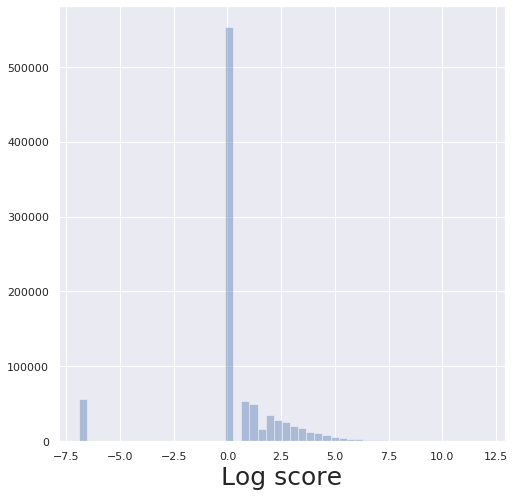

In [287]:
%matplotlib inline
posts_df['log_score'] = posts_df['score'].apply(lambda x: np.log(x+0.001))
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(posts_df['log_score'],
                 kde=False, ax=ax)
ax.set_xlabel('Log score',fontsize=25)

In [290]:
mean_log_score = posts_df['log_score'].mean()
std_log_score = posts_df['log_score'].std()
mean_log_score,std_log_score

(0.37620414110005695, 2.3589993875247104)

In [291]:
mean_log_score-0.5*std_log_score,mean_log_score+0.5*std_log_score

(-0.8032955526622982, 1.5557038348624121)

In [86]:
def partition_lo_hi_posts(posts_,metric_,lo_thresh,hi_thresh):
    
    lo_indices = posts_.loc[posts_[metric_] <= lo_thresh].index
    hi_indices = posts_.loc[posts_[metric_] >= hi_thresh].index
    
    print('Partitioning {} posts according to {} as engagement metric...'.format(len(posts_),metric_))
    print('Number of low engagement posts:',len(lo_indices))
    print('Number of high engagement posts:',len(hi_indices))
    
    return {'lo':lo_indices,'hi':hi_indices}

## Which subs do high vs. low engagement posts belong to?

In [365]:
LO_THRESH = mean_log_num_comments-0.5*std_log_num_comments
HI_THRESH = mean_log_num_comments+0.5*std_log_num_comments
partition = partition_lo_hi_posts(posts_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 911496 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 492396
Number of high engagement posts: 419100


In [366]:
# 0 vs. non-zero #comments
hi_eng_df = posts_df.iloc[partition['hi']]
lo_eng_df = posts_df.iloc[partition['lo']]

In [370]:
hi_eng_df.subreddit.value_counts().index[:20]

Index(['AskReddit', 'environment', 'politics', 'worldnews', 'climateskeptics',
       'Showerthoughts', 'climate', 'askscience', 'The_Donald', 'science',
       'EcoInternet', 'collapse', 'mechmarket', 'Futurology',
       'explainlikeimfive', 'thinkpad', 'PlantedTank', 'conspiracy',
       'NoStupidQuestions', 'australia'],
      dtype='object')

In [371]:
lo_eng_df.subreddit.value_counts().index[:20]

Index(['EcoInternet', 'TalkativePeople', 'environment', 'AutoNewspaper',
       'newsbotbot', 'climate', 'askscience', 'news', 'autotldr',
       'EvolveSustain', 'worldnews', 'science', 'unremovable', 'politics',
       'Showerthoughts', 'betternews', 'climateskeptics', 'BreakingNews24hr',
       'The_Donald', 'reddit.com'],
      dtype='object')

In [372]:
# <1 log. #comments as threshold
hi_eng_df_2 = posts_df.iloc[partition2['hi']]
lo_eng_df_2 = posts_df.iloc[partition2['lo']]

In [373]:
hi_eng_df_2.subreddit.value_counts().index[:20]

Index(['AskReddit', 'politics', 'environment', 'worldnews', 'climateskeptics',
       'The_Donald', 'collapse', 'science', 'climate', 'mechmarket',
       'thinkpad', 'PlantedTank', 'Futurology', 'NoStupidQuestions',
       'conspiracy', 'australia', 'unpopularopinion', 'explainlikeimfive',
       'askscience', 'bicycling'],
      dtype='object')

In [374]:
lo_eng_df_2.subreddit.value_counts().index[:20]

Index(['EcoInternet', 'TalkativePeople', 'environment', 'AutoNewspaper',
       'climate', 'newsbotbot', 'askscience', 'Showerthoughts', 'politics',
       'worldnews', 'science', 'news', 'AskReddit', 'climateskeptics',
       'The_Donald', 'autotldr', 'EvolveSustain', 'reddit.com', 'unremovable',
       'climatechange'],
      dtype='object')

In [375]:
# <1 log. #comments as threshold, excluding posts w/ 0 comments
hi_eng_df_3 = posts_df.iloc[partition3['hi']]
lo_eng_df_3 = posts_df.iloc[partition3['lo']]

In [376]:
hi_eng_df_3.subreddit.value_counts().index[:20]

Index(['EcoInternet', 'environment', 'AutoNewspaper', 'climate', 'AskReddit',
       'politics', 'The_Donald', 'askscience', 'newsbotbot', 'worldnews',
       'Showerthoughts', 'climateskeptics', 'science', 'news', 'reddit.com',
       'mechmarket', 'collapse', 'TalkativePeople', 'autotldr',
       'BreakingNews24hr'],
      dtype='object')

In [377]:
lo_eng_df_3.subreddit.value_counts().index[:20]

Index(['EcoInternet', 'environment', 'AutoNewspaper', 'politics', 'climate',
       'AskReddit', 'The_Donald', 'worldnews', 'askscience', 'newsbotbot',
       'climateskeptics', 'Showerthoughts', 'science', 'reddit.com',
       'TalkativePeople', 'news', 'mechmarket', 'collapse', 'autotldr',
       'BreakingNews24hr'],
      dtype='object')

Plot proportion of posts that are hi vs. lo engagement, broken down by sub:

In [475]:
# Plot proportion of posts that are hi vs. lo engagement, broken down by sub
posts_df['engagement'] = posts_df['log_score'].apply(lambda x: 'high' if x > 1 else 'low') 

In [481]:
most_common_subs_30 = posts_df.subreddit.value_counts().index[:30]
sub_groups = posts_df.groupby('subreddit')
most_common_nonzero_subs_30 = posts_df.loc[posts_df.num_comments > 0].subreddit.value_counts().index[:30]
sub_groups_nonzero = posts_df.loc[posts_df.num_comments > 0].groupby('subreddit')
most_common_nonniche_subs_30 = posts_df.loc[~posts_df.subreddit.isin(niche_subs)].subreddit.value_counts().index[:30]
sub_groups_nonniche = posts_df.loc[~posts_df.subreddit.isin(niche_subs)].groupby('subreddit')
most_common_nonzero_nonniche_subs_30 = posts_df.loc[(posts_df.num_comments > 0) & 
                                                   (~posts_df.subreddit.isin(niche_subs))].subreddit.value_counts().index[:30]
sub_groups_nonzero_nonniche = posts_df.loc[(posts_df.num_comments > 0) &
                                          (~posts_df.subreddit.isin(niche_subs))].groupby('subreddit')

In [476]:
posts_df.engagement.value_counts()

low     662207
high    249289
Name: engagement, dtype: int64

In [484]:
subs_df_ = []
counts_df_ = []
engs_df_ = []

for sub in most_common_nonniche_subs_30:
    sub_df = sub_groups_nonniche.get_group(sub)
    sub_eng_counts = sub_df.engagement.value_counts()
    hi_count = sub_eng_counts['high'] if 'high' in sub_eng_counts else 0
    lo_count = sub_eng_counts['low'] if 'low' in sub_eng_counts else 0
    subs_df_.extend([sub,sub])
    counts_df_.extend([hi_count,lo_count])
    engs_df_.extend(['high','low'])
    
df_ = pd.DataFrame({"subreddit":subs_df_,
                   "post count":counts_df_,
                   "engagement":engs_df_})

Text(0.5, 1.0, 'High engagement = log score > 1, exclude posts from niche-interest subs')

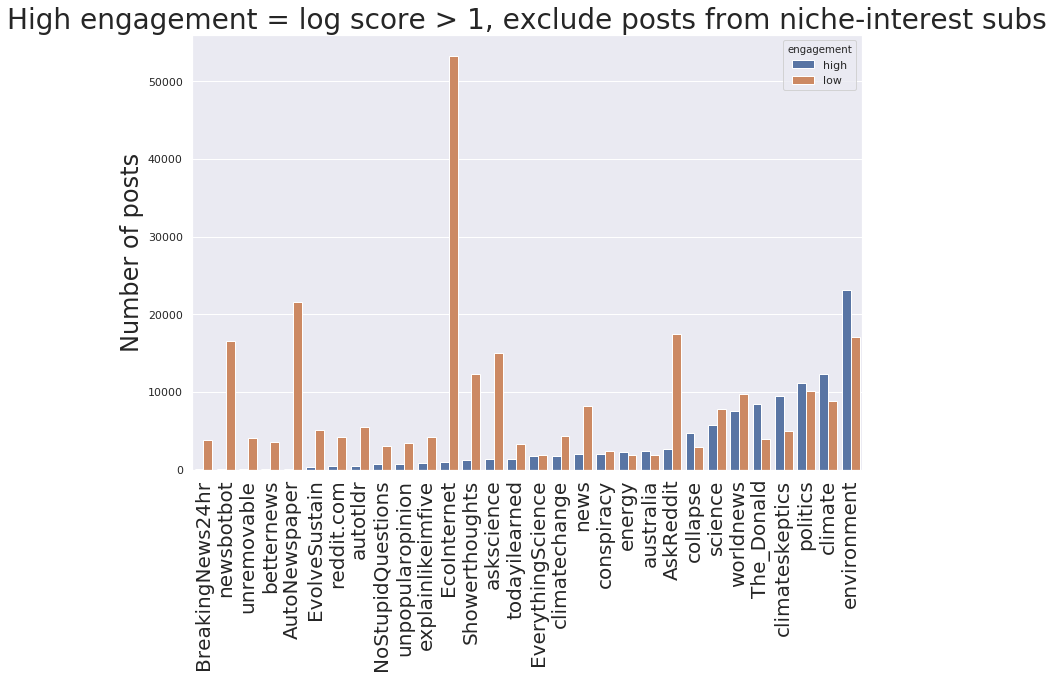

In [485]:
fig,ax = plt.subplots(figsize=(12,8))
g = sns.barplot(x="subreddit",y="post count",data=df_.sort_values(['engagement','post count']),hue="engagement")
ax.set_ylabel('Number of posts',fontsize=24)
ax.set_xlabel('',fontsize=24)
ax.set_xticklabels(g.get_xticklabels(),rotation=90,fontsize=20)
ax.set_title("High engagement = log score > 1, exclude posts from niche-interest subs",fontsize=28)

## LOR words in high vs. low engagement posts

Log odds analyses (by engagement, by stance)
1. Posts
    * A. separate title from body and analyze separately; then together
    * B. try different thresholds for partitioning into lo and hi engagement
    * C. exclude niche interest subreddits
    * D. engagement based on score rather than length
1. Above addresses what posts are about. But what are the comments in long vs. shorter threads talking about?
1. apply other potential categories to data comparisons (e.g. whether original post mentions climate change)

In [637]:
def lor_report(df_,g1_indices,g2_indices,X_str,n_to_label=40):
    
    # Get X for groups 1 and 2
    print('Partitioning data into groups')
    if X_str == 'comments':
        # go from post to comment indices:
        g1_posts = df_.iloc[g1_indices]
        g2_posts = df_.iloc[g2_indices]
        
        g1_comm_ids = [post2comment_ids[p_id] for p_id in g1_posts['id']] # list of lists
        g1_comm_ids = [item for sublist in g1_comm_ids for item in sublist] # flat list
        
        g2_comm_ids = [post2comment_ids[p_id] for p_id in g2_posts['id']] # list of lists
        g2_comm_ids = [item for sublist in g2_comm_ids for item in sublist] # flat list
        
        # then go from comment indices to comment lemmas
        hi_eng_lems = [comment_id2lemmas[comm_id] for comm_id in g1_comm_ids
                         if comm_id in comment_id2lemmas] 
        lo_eng_lems = [comment_id2lemmas[comm_id] for comm_id in g2_comm_ids
                         if comm_id in comment_id2lemmas] 
    elif X_str == 'both':
        hi_eng_lems = [json.loads(p['title_lemmas']) + json.loads(p['body_lemmas']) 
                             for _,p in df_.iloc[g1_indices].iterrows() 
                            if p['body_lemmas'] is not None]
        lo_eng_lems = [json.loads(p['title_lemmas']) + json.loads(p['body_lemmas'])
                             for _,p in df_.iloc[g2_indices].iterrows()
                            if p['body_lemmas'] is not None]
    else:
        hi_eng_lems = [json.loads(p[X_str]) for _,p in df_.iloc[g1_indices].iterrows() 
                            if p[X_str] is not None]
        lo_eng_lems = [json.loads(p[X_str]) for _,p in df_.iloc[g2_indices].iterrows()
                            if p[X_str] is not None]
    hi_eng_lems = [item for sublist in hi_eng_lems for item in sublist]
    lo_eng_lems = [item for sublist in lo_eng_lems for item in sublist]
    
    # Exclude non-alpha
    hi_eng_lems = [x for x in hi_eng_lems if x.isalpha()]
    lo_eng_lems = [x for x in lo_eng_lems if x.isalpha()]
    print("Excluding non-alpha tokens. Number of tokens in 2 post groups:",len(hi_eng_lems),len(lo_eng_lems))
    N_hi, N_lo = len(hi_eng_lems), len(lo_eng_lems)
    
    # Exclude non-nltk words
    hi_eng_lems = [x for x in hi_eng_lems if x in WORDS]
    lo_eng_lems = [x for x in lo_eng_lems if x in WORDS]
    print("Excluding non-nltk words. Number of tokens in 2 post groups:",len(hi_eng_lems),len(lo_eng_lems))
    N_hi, N_lo = len(hi_eng_lems), len(lo_eng_lems)
    
    hi_eng_vocab = set(hi_eng_lems)
    lo_eng_vocab = set(lo_eng_lems)
    print("Vocab size of hi, lo engagement posts:",len(hi_eng_vocab),len(lo_eng_vocab))
    
    joint_vocab = hi_eng_vocab.intersection(lo_eng_vocab)
    print('Size of joint vocab:',len(joint_vocab))
    print('Proportion of joint vocab in hi:',len(joint_vocab)/len(hi_eng_vocab))
    print('Proportion of joint vocab in lo:',len(joint_vocab)/len(lo_eng_vocab))
    
    vocab_counts_hi = Counter(hi_eng_lems)
    vocab_counts_lo = Counter(lo_eng_lems)
    L_O_R_dict = {w: log_odds_ratio(vocab_counts_hi[w],N_hi,vocab_counts_lo[w],N_lo)
             for w in joint_vocab}
    
    # Plot LOR[w] against its frequency (sum over counts in hi and lo corpora)
    lor_df = pd.DataFrame(L_O_R_dict.items())
    lor_df.columns = ['word','lor_hi_to_lo']
    lor_df['freq'] = [vocab_counts_hi[w]+vocab_counts_lo[w] for w in lor_df['word']]
    lor_df['log_freq'] = lor_df['freq'].apply(lambda x: np.log(x))
    lor_df['lor_abs'] = lor_df['lor_hi_to_lo'].apply(lambda x: abs(x))
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x='log_freq',y='lor_hi_to_lo',data=lor_df,size="lor_abs",
                sizes=(5, 100), alpha=1)
    ax.set_xlabel('Frequency of word across all posts',fontsize=24)
    ax.set_ylabel('LOR of word (hi vs. lo eng. posts)',fontsize=24)

    df_to_label = lor_df.sort_values('lor_abs')[-1*n_to_label:]
    label_point(df_to_label['log_freq'], df_to_label['lor_hi_to_lo'], df_to_label['word'], ax)
    
    return lor_df

In [40]:
LO_THRESH = mean_log_num_comments-0.5*std_log_num_comments
HI_THRESH = mean_log_num_comments+0.5*std_log_num_comments
LOW_THRESH,HI_THRESH

(-5.1874753857279465, -0.8952216297312008)

In [91]:
partition = partition_lo_hi_posts(posts_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 911496 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 492396
Number of high engagement posts: 419100


#### 1Ai.) Y = len (num comments); X = title lemmas; partition = {posts w/ 0 comments, posts w/ non-0 comments}

In [353]:
#lor_df_1 = lor_report(posts_df,partition['hi'],partition['lo'],'title_lemmas')

In [212]:
#lor_df_1.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Aii.) Y = len (num comments); X = body lemmas; partition = {posts w/ 0 comments, posts w/ non-0 comments}

In [352]:
#lor_df_2 = lor_report(posts_df,partition['hi'],partition['lo'],'body_lemmas')

In [217]:
#lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Aiii.) Y = len (num comments); X = title and body lemmas; partition = {posts w/ 0 comments, posts w/ non-0 comments}

In [354]:
# Exclude non-nltk words
#lor_df_3 = lor_report(posts_df,partition['hi'],partition['lo'],'both')

In [220]:
#lor_df_3.sort_values('lor_hi_to_lo',ascending=False)[-20:]

Try new partition:

In [187]:
LO_THRESH = 1
HI_THRESH = 1.0005
partition2 = partition_lo_hi_posts(posts_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 911496 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 663696
Number of high engagement posts: 247800


#### 1Bi.) Y = len (num comments); X = title lemmas; partition = {posts w/ <=1 log #comments, posts w/ >1 log #comments}

In [355]:
#lor_df_4 = lor_report(posts_df,partition2['hi'],partition2['lo'],'title_lemmas')

In [223]:
#lor_df_4.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Bii.) Y = len (num comments); X = body lemmas; partition = {posts w/ <=1 log #comments, posts w/ >1 log #comments}


In [356]:
#lor_df_5 = lor_report(posts_df,partition2['hi'],partition2['lo'],'body_lemmas')

In [237]:
#lor_df_5.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Biii.) Y = len (num comments); X = title and body lemmas; partition = {posts w/ <=1 log #comments, posts w/ >1 log #comments}


In [357]:
#lor_df_6 = lor_report(posts_df,partition2['hi'],partition2['lo'],'both')

In [240]:
#lor_df_6.sort_values('lor_hi_to_lo',ascending=False)[-20:]

Same as above, but exclude 0-comment posts entirely

In [498]:
base_df = posts_df.loc[posts_df.num_comments > 0]
base_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1
HI_THRESH = 1.0005
partition3 = partition_lo_hi_posts(base_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 419100 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 171300
Number of high engagement posts: 247800


#### 1Biv.) Y = len (num comments); X = title lemmas; partition = {posts w/ >0 and <=1 log #comments, posts w/ >1 log #comments}


In [358]:
#lor_df_7 = lor_report(base_df,partition3['hi'],partition3['lo'],'title_lemmas',n_to_label=60)

In [244]:
#lor_df_7.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Bv.) Y = len (num comments); X = body lemmas; partition = {posts w/ >0 and <=1 log #comments, posts w/ >1 log #comments}


In [359]:
#lor_df_8 = lor_report(base_df,partition3['hi'],partition3['lo'],'body_lemmas',n_to_label=60)

In [247]:
#lor_df_8.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Bvi.) Y = len (num comments); X = title and body lemmas; partition = {posts w/ >0 and <=1 log #comments, posts w/ >1 log #comments}


In [360]:
#lor_df_9 = lor_report(base_df,partition3['hi'],partition3['lo'],'both',n_to_label=70)

In [250]:
#lor_df_9.sort_values('lor_hi_to_lo',ascending=False)[-20:]

Let's try excluding posts from niche-interest subreddits.

In [464]:
niche_subs = set(['mechmarket','PlantedTank','bicycling','Aquariums','microgrowery','Homebrewing',
             'vegan','cycling','chemistry','carporn','TalkativePeople','thinkpad','mechmarket','spacex','space',
                 'Futurology','bikewrench','airsoftmarket','airsoft'])
# 'Futurology'

In [266]:
non_niche_subs = set(['AskReddit','environment','politics','worldnews','climateskeptics',
                     'Showerthoughts','climate','askscience','The_Donald','science','EcoInternet',
                     'collapse','explainlikeimfive','conspiracy','NoStupidQuestions','australia',
                     'unpopularopinion','climatechange','news','energy','canada','Conservative',
                     'skeptic','todayilearned','shittyaskscience','ChapoTrapHouse','CanadaPolitics',
                     'EverythingScience','worldpolitics','europe','AskScienceDiscussion',
                     'ClimateOffensive','changemyview','ClimateActionPlan','AskTrumpSupporters',
                     'GlobalWarming','GlobalClimateChange','esist','Green'])

In [227]:
list(base_df.subreddit.value_counts().index)[:100]

['AskReddit',
 'environment',
 'politics',
 'worldnews',
 'climateskeptics',
 'Showerthoughts',
 'climate',
 'askscience',
 'The_Donald',
 'science',
 'EcoInternet',
 'collapse',
 'mechmarket',
 'Futurology',
 'explainlikeimfive',
 'thinkpad',
 'PlantedTank',
 'conspiracy',
 'NoStupidQuestions',
 'australia',
 'unpopularopinion',
 'climatechange',
 'news',
 'energy',
 'canada',
 'bicycling',
 'Conservative',
 'skeptic',
 'todayilearned',
 'shittyaskscience',
 'videos',
 'ChapoTrapHouse',
 'airsoft',
 'Aquariums',
 'CanadaPolitics',
 'EverythingScience',
 'teenagers',
 'memes',
 'worldpolitics',
 'knifeclub',
 'WritingPrompts',
 'reddit.com',
 'pics',
 'Libertarian',
 'nottheonion',
 'ModerationLog',
 'hardwareswap',
 'technology',
 'dankmemes',
 'microgrowery',
 'SandersForPresident',
 'europe',
 'MechanicalKeyboards',
 'Homebrewing',
 'newsbotbot',
 'metacanada',
 'Eve',
 'Knife_Swap',
 'AskScienceDiscussion',
 'atheism',
 'WayOfTheBern',
 'ClimateOffensive',
 'funny',
 'dataisbeautif

In [499]:
non_niche_df = base_df.loc[~base_df.subreddit.isin(niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 2
HI_THRESH = 2.0005
partition4 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 389448 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 264670
Number of high engagement posts: 124778


#### 1Ci.) Y = len (num comments); X = title lemmas; partition = {posts w/ >0 and <=2 log #comments, posts w/ >2 log #comments}; exclude niche interest posts

In [607]:
#lor_df_10 = lor_report(base_df,partition4['hi'],partition4['lo'],'title_lemmas',n_to_label=60)

In [608]:
#lor_df_10.sort_values('lor_hi_to_lo',ascending=False)[:20]

In [609]:
#lor_df_10.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Cii.) Y = len (num comments); X = body lemmas; partition = {posts w/ >0 and <=2 log #comments, posts w/ >2 log #comments}; exclude niche interest posts

In [610]:
#lor_df_11 = lor_report(base_df,partition4['hi'],partition4['lo'],'body_lemmas',n_to_label=60)

In [611]:
# attempt 2
#lor_df_11.sort_values('lor_hi_to_lo',ascending=False)[-20:]

#### 1Ciii.) Y = len (num comments); X = title and body lemmas; partition = {posts w/ >0 and <=2 log #comments, posts w/ >2 log #comments}; exclude niche interest posts

In [612]:
#lor_df_12 = lor_report(base_df,partition4['hi'],partition4['lo'],'both',n_to_label=60)

In [613]:
#lor_df_12.sort_values('lor_hi_to_lo',ascending=False)[-20:]

Now include only a set of news, climate related subs.

In [509]:
non_niche_df = base_df.loc[base_df.subreddit.isin(non_niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 2
HI_THRESH = 2.0005
partition5 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 190470 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 129319
Number of high engagement posts: 61151


#### 1Civ.) Y = len (num comments); X = title lemmas; partition = {posts w/ >0 and <=2 log #comments, posts w/ >2 log #comments}; include only non-niche interest posts

In [614]:
#lor_df_13 = lor_report(non_niche_df,partition5['hi'],partition5['lo'],'title_lemmas',n_to_label=60)

In [615]:
#lor_df_13.sort_values('lor_hi_to_lo',ascending=False)[:50]

In [616]:
#lor_df_13.sort_values('lor_hi_to_lo',ascending=False)[-30:]

#### 1Cv.) Y = len (num comments); X = body lemmas; partition = {posts w/ >0 and <=2 log #comments, posts w/ >2 log #comments}; include only non-niche interest posts

In [617]:
#lor_df_14 = lor_report(non_niche_df,partition5['hi'],partition5['lo'],'body_lemmas',n_to_label=60)

In [618]:
#lor_df_14.sort_values('lor_hi_to_lo',ascending=False)[:50]

In [619]:
#lor_df_14.sort_values('lor_hi_to_lo',ascending=False)[-30:]

#### 1Cvi.) Y = len (num comments); X = title and body lemmas; partition = {posts w/ >0 and <=2 log #comments, posts w/ >2 log #comments}; include only non-niche interest posts

In [620]:
#lor_df_15 = lor_report(non_niche_df,partition5['hi'],partition5['lo'],'both',n_to_label=60)

In [621]:
#lor_df_15.sort_values('lor_hi_to_lo',ascending=False)[-30:]

Try using score as engagement signal instead of length.

In [524]:
non_niche_df = posts_df.loc[posts_df.subreddit.isin(non_niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1.5
HI_THRESH = 1.5005
partition6 = partition_lo_hi_posts(non_niche_df,'log_score',LO_THRESH,HI_THRESH)

Partitioning 334341 posts according to log_score as engagement metric...
Number of low engagement posts: 235170
Number of high engagement posts: 99171


#### 1Di.) Y = log score; X = title lemmas; partition = {posts w/ <=1.5 log score posts w/ >1.5 log score}; include only non-niche interest posts

In [297]:
lor_df_16 = lor_report(non_niche_df,partition6['hi'],partition6['lo'],'title_lemmas',n_to_label=60)

In [622]:
#lor_df_16.sort_values('lor_hi_to_lo',ascending=False)[:50]

#### 1Dii.) Y = log score; X = body lemmas; partition = {posts w/ <=1.5 log score posts w/ >1.5 log score}; include only non-niche interest posts

In [363]:
#lor_df_17 = lor_report(non_niche_df,partition6['hi'],partition6['lo'],'body_lemmas',n_to_label=60)

In [623]:
#lor_df_17.sort_values('lor_hi_to_lo',ascending=False)[:50]

#### 1Diii.) Y = log score; X = title and body lemmas; partition = {posts w/ <=1.5 log score posts w/ >1.5 log score}; include only non-niche interest posts

In [364]:
#lor_df_18 = lor_report(non_niche_df,partition6['hi'],partition6['lo'],'both',n_to_label=60)

In [624]:
#lor_df_18.sort_values('lor_hi_to_lo',ascending=False)[:50]

## LOR words in comments of high vs. low engagement posts

In [532]:
post_id = 'anbg0'
posts_df.loc[posts_df.id==post_id]

,id,title,url,author,score,date,num_comments,permalink,flair,is_video,...,title_num_words,body_num_words,total_num_words,parsed_date,year,log_num_comments,title_lemmas,body_lemmas,log_score,engagement
5,anbg0,Scientists have uncovered what appears to be a...,http://news.bbc.co.uk/1/hi/sci/tech/8437703.stm,gIowingsheep,34,2010-01-08 16:40:15,3,/r/environment/comments/anbg0/scientists_have_...,NaN,False,...,24,0,24,2010-01-08 16:40:15,2010,1.098946,"[""scientist"", ""have"", ""uncovered"", ""what"", ""ap...",None,3.52639,high


In [568]:
known_post_ids = set(comment_ids_per_post['post_id'])
len(known_post_ids)

112365

In [569]:
known_posts_df = posts_df.loc[posts_df['id'].isin(known_post_ids)]
known_posts_df.shape

(112365, 23)

In [553]:
comment_texts_df = pd.read_csv('text_per_comment.tsv',sep='\t',header=0)
comment_texts_df.head(),comment_texts_df.shape

comment_texts_df = comment_texts_df.loc[~pd.isnull(comment_texts_df.text)]
print(comment_texts_df.shape)
comment_texts_df['lemmas'] = comment_texts_df.text.apply(get_lemmas)

(143274, 2)


In [555]:
#comment_texts_df.to_pickle('lemmatized_comment_texts.pkl')

In [562]:
comment_id2lemmas = dict(zip(comment_texts_df['comment_id'],
                            comment_texts_df['lemmas'].apply(lambda x: json.loads(x))))

In [563]:
comment_id2lemmas['d7fdpm4']

['that',
 "'s",
 'fair',
 '.',
 'thank',
 'you',
 'for',
 'have',
 'the',
 'courtesy',
 'to',
 'explain',
 'it',
 '.']

In [576]:
def lor_report_comments(df_,g1_indices,g2_indices,X_str,n_to_label=40):
    
    # Get X for groups 1 and 2
    print('Partitioning data into groups')
    if True:#X_str == 'both':
        # g1, g2 are post indices for hi, lo engagement
        
        # go from post to comment indices:
        g1_posts = df_.iloc[g1_indices]
        g2_posts = df_.iloc[g2_indices]
        
        g1_comm_ids = [post2comment_ids[p_id] for p_id in g1_posts['id']] # list of lists
        g1_comm_ids = [item for sublist in g1_comm_ids for item in sublist] # flat list
        
        g2_comm_ids = [post2comment_ids[p_id] for p_id in g2_posts['id']] # list of lists
        g2_comm_ids = [item for sublist in g2_comm_ids for item in sublist] # flat list
        
        # then go from comment indices to comment lemmas
        g1_comm_lemmas = [comment_id2lemmas[comm_id] for comm_id in g1_comm_ids
                         if comm_id in comment_id2lemmas] # list of lists
        g1_comm_lemmas = [item for sublist in g1_comm_lemmas for item in sublist]
        
        g2_comm_lemmas = [comment_id2lemmas[comm_id] for comm_id in g2_comm_ids
                         if comm_id in comment_id2lemmas] # list of lists
        g2_comm_lemmas = [item for sublist in g2_comm_lemmas for item in sublist]
    else:
        hi_eng_title_lems = [json.loads(p[X_str]) for _,p in df_.iloc[g1_indices].iterrows() 
                            if p[X_str] is not None]
        lo_eng_title_lems = [json.loads(p[X_str]) for _,p in df_.iloc[g2_indices].iterrows()
                            if p[X_str] is not None]
#     hi_eng_title_lems = [item for sublist in hi_eng_title_lems for item in sublist]
#     lo_eng_title_lems = [item for sublist in lo_eng_title_lems for item in sublist]
    hi_eng_title_lems = g1_comm_lemmas
    lo_eng_title_lems = g2_comm_lemmas
    
    # Exclude non-alpha
    hi_eng_title_lems = [x for x in hi_eng_title_lems if x.isalpha()]
    lo_eng_title_lems = [x for x in lo_eng_title_lems if x.isalpha()]
    print("Excluding non-alpha tokens. Number of tokens in 2 post groups:",len(hi_eng_title_lems),len(lo_eng_title_lems))
    N_hi, N_lo = len(hi_eng_title_lems), len(lo_eng_title_lems)
    
    # Exclude non-nltk words
    hi_eng_title_lems = [x for x in hi_eng_title_lems if x in WORDS]
    lo_eng_title_lems = [x for x in lo_eng_title_lems if x in WORDS]
    print("Excluding non-nltk words. Number of tokens in 2 post groups:",len(hi_eng_title_lems),len(lo_eng_title_lems))
    N_hi, N_lo = len(hi_eng_title_lems), len(lo_eng_title_lems)
    
    hi_eng_title_vocab = set(hi_eng_title_lems)
    lo_eng_title_vocab = set(lo_eng_title_lems)
    print("Vocab size of hi, lo engagement posts:",len(hi_eng_title_vocab),len(lo_eng_title_vocab))
    
    joint_vocab = hi_eng_title_vocab.intersection(lo_eng_title_vocab)
    print('Size of joint vocab:',len(joint_vocab))
    print('Proportion of joint vocab in hi:',len(joint_vocab)/len(hi_eng_title_vocab))
    print('Proportion of joint vocab in lo:',len(joint_vocab)/len(lo_eng_title_vocab))
    
    vocab_counts_hi = Counter(hi_eng_title_lems)
    vocab_counts_lo = Counter(lo_eng_title_lems)
    L_O_R_dict = {w: log_odds_ratio(vocab_counts_hi[w],N_hi,vocab_counts_lo[w],N_lo)
             for w in joint_vocab}
    
    # Plot LOR[w] against its frequency (sum over counts in hi and lo corpora)
    lor_df = pd.DataFrame(L_O_R_dict.items())
    lor_df.columns = ['word','lor_hi_to_lo']
    lor_df['freq'] = [vocab_counts_hi[w]+vocab_counts_lo[w] for w in lor_df['word']]
    lor_df['log_freq'] = lor_df['freq'].apply(lambda x: np.log(x))
    lor_df['lor_abs'] = lor_df['lor_hi_to_lo'].apply(lambda x: abs(x))
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x='log_freq',y='lor_hi_to_lo',data=lor_df,size="lor_abs",
                sizes=(5, 100), alpha=1)
    ax.set_xlabel('Frequency of word across all posts comments',fontsize=24)
    ax.set_ylabel('LOR of word (hi vs. lo eng. posts)',fontsize=24)

    df_to_label = lor_df.sort_values('lor_abs')[-1*n_to_label:]
    label_point(df_to_label['log_freq'], df_to_label['lor_hi_to_lo'], df_to_label['word'], ax)
    
    return lor_df

In [639]:
non_niche_df = known_posts_df.loc[~known_posts_df.subreddit.isin(niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 2
HI_THRESH = 2.0005
comm_partition1 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 101741 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 69262
Number of high engagement posts: 32479


Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups: 5659602 688017
Excluding non-nltk words. Number of tokens in 2 post groups: 5440091 653670
Vocab size of hi, lo engagement posts: 21679 11726
Size of joint vocab: 11082
Proportion of joint vocab in hi: 0.5111859403108999
Proportion of joint vocab in lo: 0.9450793109329695


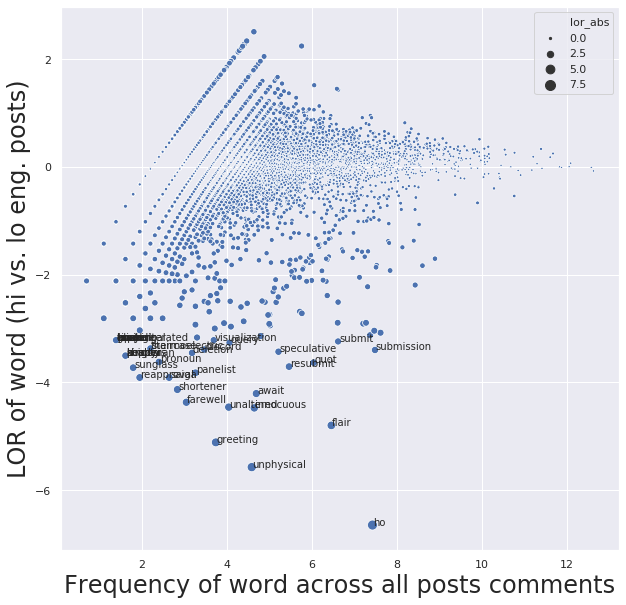

In [640]:
# Words in comments of hi vs. lo engagement posts (engagement = log #comments > 2); exclude posts in niche subs
comm_lor_df_1 = lor_report(non_niche_df,comm_partition1['hi'],comm_partition1['lo'],"comments")

In [626]:
#comm_lor_df_1.sort_values('lor_hi_to_lo',ascending=False)[:50]

In [581]:
known_posts_df.reset_index(drop=True,inplace=True)
LO_THRESH = 2
HI_THRESH = 2.0005
comm_partition2 = partition_lo_hi_posts(known_posts_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 112365 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 75469
Number of high engagement posts: 36896


In [627]:
# no sub exclusion
#comm_lor_df_2 = lor_report_comments(known_posts_df,comm_partition2['hi'],comm_partition2['lo'],"")

In [628]:
#comm_lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[-50:]

In [587]:
known_posts_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1
HI_THRESH = 1.0005
comm_partition3 = partition_lo_hi_posts(known_posts_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 112365 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 44492
Number of high engagement posts: 67873


In [629]:
# no sub exclusion, use 1 as threshold
#comm_lor_df_3 = lor_report_comments(known_posts_df,comm_partition3['hi'],comm_partition3['lo'],"")

In [630]:
#comm_lor_df_3.sort_values('lor_hi_to_lo',ascending=False)[-50:]

Use 1 as threshold, now exclude niche subs

In [591]:
non_niche_df = known_posts_df.loc[~known_posts_df.subreddit.isin(niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1
HI_THRESH = 1.0005
comm_partition4 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 101741 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 42269
Number of high engagement posts: 59472


In [631]:
#comm_lor_df_4 = lor_report_comments(non_niche_df,comm_partition4['hi'],comm_partition4['lo'],"")

In [632]:
#comm_lor_df_4.sort_values('lor_hi_to_lo',ascending=False)[-50:]

Same threshold of 1, now only include news general subs.

In [597]:
non_niche_df = known_posts_df.loc[known_posts_df.subreddit.isin(non_niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1
HI_THRESH = 1.0005
comm_partition5 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 45156 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 19834
Number of high engagement posts: 25322


In [596]:
non_niche_subs

{'AskReddit',
 'AskScienceDiscussion',
 'AskTrumpSupporters',
 'CanadaPolitics',
 'ChapoTrapHouse',
 'ClimateActionPlan',
 'ClimateOffensive',
 'Conservative',
 'EcoInternet',
 'EverythingScience',
 'GlobalClimateChange',
 'GlobalWarming',
 'Green',
 'NoStupidQuestions',
 'Showerthoughts',
 'The_Donald',
 'askscience',
 'australia',
 'canada',
 'changemyview',
 'climate',
 'climatechange',
 'climateskeptics',
 'collapse',
 'conspiracy',
 'energy',
 'environment',
 'esist',
 'europe',
 'explainlikeimfive',
 'news',
 'politics',
 'science',
 'shittyaskscience',
 'skeptic',
 'todayilearned',
 'unpopularopinion',
 'worldnews',
 'worldpolitics'}

In [633]:
#comm_lor_df_5 = lor_report_comments(non_niche_df,comm_partition5['hi'],comm_partition5['lo'],"")

In [634]:
#comm_lor_df_5.sort_values('lor_hi_to_lo',ascending=False)[-50:]

Increase threshold to 2

In [602]:
non_niche_df = known_posts_df.loc[known_posts_df.subreddit.isin(non_niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 2
HI_THRESH = 2.0005
comm_partition6 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 45156 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 30891
Number of high engagement posts: 14265


In [635]:
#comm_lor_df_6 = lor_report_comments(non_niche_df,comm_partition6['hi'],comm_partition6['lo'],"")

In [636]:
#comm_lor_df_6.sort_values('lor_hi_to_lo',ascending=False)[-50:]

# Log odds ratios of words in liberal vs. conservative posts

In [337]:
annotated_subs.cc_stance.value_counts()

n    26
p    23
a     4
Name: cc_stance, dtype: int64

In [335]:
sub2stance = dict(zip(annotated_subs['subreddit_name'].apply(lambda x: x[2:]),annotated_subs['cc_stance']))

In [336]:
sub2stance['ChapoTrapHouse'] = 'p'

In [344]:
subs_with_annots = set([x for x in sub2stance if sub2stance[x] is not None])
#subs_with_annots

In [488]:
annotated_df = posts_df.loc[(posts_df.subreddit.isin(subs_with_annots)) & (~posts_df.subreddit.isin(niche_subs))]
annotated_df.reset_index(inplace=True,drop=True)
len(annotated_df)
annotated_df['cc_stance'] = annotated_df.subreddit.apply(lambda x: sub2stance[x] if x in sub2stance else None)

liberal_df = annotated_df.loc[annotated_df.cc_stance=='p']
conservative_df = annotated_df.loc[annotated_df.cc_stance=='a']
neutral_df = annotated_df.loc[annotated_df.cc_stance=='n']

/u/nlp/anaconda/main/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups: 3642871 534855
Excluding non-nltk words. Number of tokens in 2 post groups: 3424329 496290
Vocab size of hi, lo engagement posts: 16978 10366
Size of joint vocab: 9413
Proportion of joint vocab in hi: 0.5544233714218401
Proportion of joint vocab in lo: 0.9080648273200849


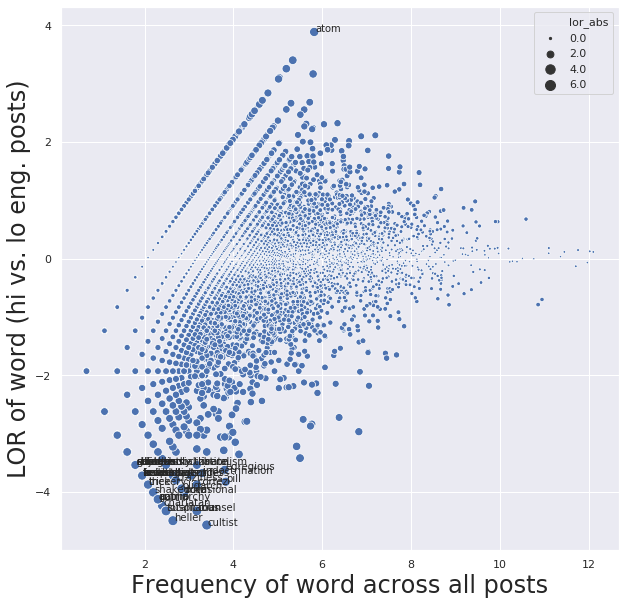

In [489]:
stance_lor_df_1 = lor_report(annotated_df,liberal_df.index,
           conservative_df.index,'title_lemmas',n_to_label=40)

In [491]:
# Most conservative post title words
stance_lor_df_1.sort_values('lor_hi_to_lo',ascending=False)[:50]

,word,lor_hi_to_lo,freq,log_freq,lor_abs
567,atom,3.885707,337,5.820083,3.885707
2915,organism,3.401277,208,5.337538,3.401277
2651,catalyst,3.255936,180,5.192957,3.255936
5097,element,3.165404,329,5.796058,3.165404
815,carbonate,3.098980,154,5.036953,3.098980
967,activate,3.079177,151,5.017280,3.079177
5339,vulnerability,2.839217,119,4.779123,2.839217
8281,traditional,2.712919,105,4.653960,2.712919
7053,indigenous,2.680396,305,5.720312,2.680396
1958,pension,2.663673,200,5.298317,2.663673


Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups: 1061846 370867
Excluding non-nltk words. Number of tokens in 2 post groups: 1020793 351778
Vocab size of hi, lo engagement posts: 13101 9317
Size of joint vocab: 7818
Proportion of joint vocab in hi: 0.5967483398213876
Proportion of joint vocab in lo: 0.8391113019212193


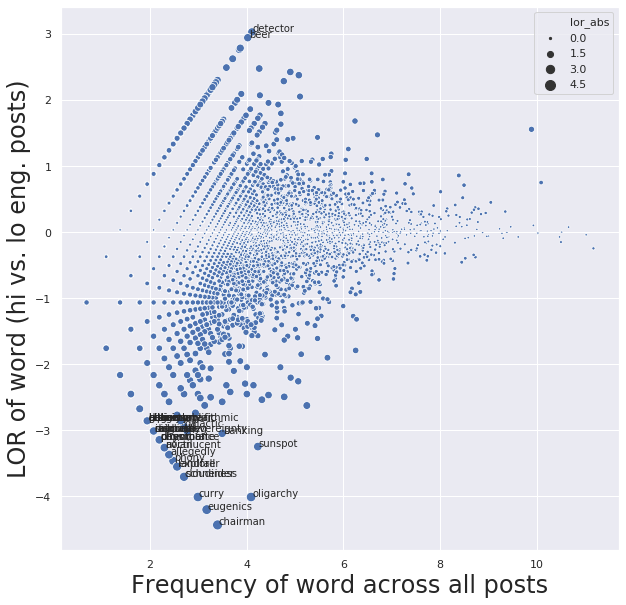

In [492]:
stance_lor_df_2 = lor_report(annotated_df,liberal_df.index,
           conservative_df.index,'body_lemmas',n_to_label=40)

In [493]:
# Most conservative post body words
stance_lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[-50:]

,word,lor_hi_to_lo,freq,log_freq,lor_abs
7600,persecution,-2.674786,6,1.791759,2.674786
2390,pearl,-2.674786,6,1.791759,2.674786
6469,discretion,-2.674786,6,1.791759,2.674786
2068,intimidation,-2.674786,6,1.791759,2.674786
4661,heartless,-2.674786,6,1.791759,2.674786
6859,opaque,-2.674786,6,1.791759,2.674786
6435,bombed,-2.674786,6,1.791759,2.674786
1408,inaccuracy,-2.739354,19,2.944439,2.739354
3630,laureate,-2.739354,19,2.944439,2.739354
6529,assassinate,-2.770112,13,2.564949,2.770112


In [494]:
# Most liberal post body words
stance_lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[:50]

,word,lor_hi_to_lo,freq,log_freq,lor_abs
1584,detector,3.029066,61,4.110874,3.029066
1684,beer,2.942049,56,4.025352,2.942049
7558,inhale,2.784856,48,3.871201,2.784856
3127,plate,2.763349,47,3.850148,2.763349
5432,soda,2.623581,41,3.713572,2.623581
7104,burnt,2.490045,36,3.583519,2.490045
4791,sleep,2.475686,71,4.262680,2.475686
3471,bond,2.423685,135,4.905275,2.423685
486,atom,2.375222,161,5.081404,2.375222
2472,shipping,2.301987,30,3.401197,2.301987


Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups: 1659656 454373
Excluding non-nltk words. Number of tokens in 2 post groups: 1597264 430421
Vocab size of hi, lo engagement posts: 14524 9917
Size of joint vocab: 8532
Proportion of joint vocab in hi: 0.5874414761773616
Proportion of joint vocab in lo: 0.8603408288797015


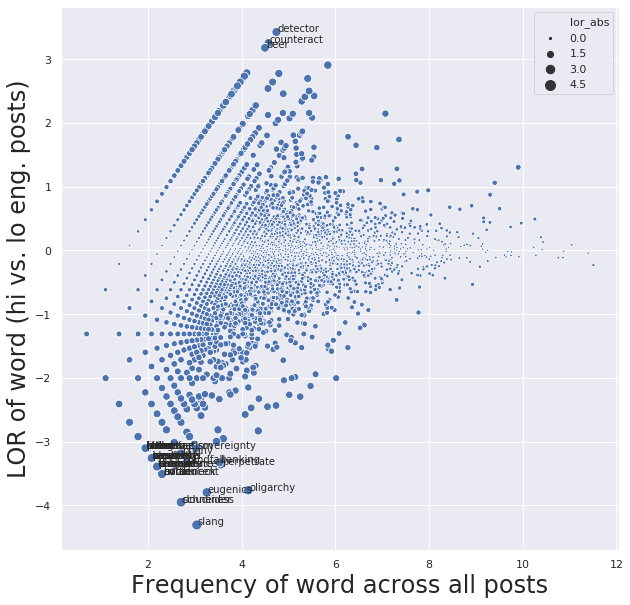

In [495]:
stance_lor_df_3 = lor_report(annotated_df,liberal_df.index,
           conservative_df.index,'both',n_to_label=40)

In [497]:
stance_lor_df_3.sort_values('lor_hi_to_lo',ascending=False)[:50]

,word,lor_hi_to_lo,freq,log_freq,lor_abs
1732,detector,3.424984,115,4.744932,3.424984
1725,counteract,3.253122,97,4.574711,3.253122
1841,beer,3.177406,90,4.499810,3.177406
525,atom,2.905479,344,5.840642,2.905479
142,respiration,2.783096,61,4.110874,2.783096
5919,soda,2.774763,121,4.795791,2.774763
1911,suffocate,2.731801,58,4.060443,2.731801
257,scrubber,2.714101,57,4.043051,2.714101
3790,bond,2.696178,224,5.411646,2.696178
5227,sleep,2.640021,106,4.663439,2.640021


Now look at neutral vs. liberal+conservative together

In [350]:
stance_lor_df_4 = lor_report(annotated_df,liberal_df.index+conservative_df.index,
           neutral_df.index,'title_lemmas',n_to_label=40)

ValueError: operands could not be broadcast together with shapes (243727,) (34874,) 

In [ ]:
stance_lor_df_4.sort_values('lor_hi_to_lo',ascending=False)[-50:]